In [1]:
# file wrapper-concept.ipynb
# author Jim Smith Jan 2022
# note book to explore and illustrate the basic concept of a wrapper class

## Some basic examples to explore what the wrapper class could look like and be implemented

### Lets start by making some data with one disclosive case
- We'll do this by adding an example to the iris data and give it a new class to make things really obvious.
- The same risks exist for more complex data sets but _everyone knows iris_

In [2]:
!pip install numpy
import numpy as np
from sklearn import datasets 

iris= datasets.load_iris()
X= iris.data
y = iris.target



#print the max and min values in each feature to help hand-craft the disclosive point
for  feature in range (4):
    print (f'feature {feature} min {np.min(X[:,feature])}, min {np.max(X[:,feature])}')
    
# now add a single disclosve point with features [7,2,4.5,1] and label 3
X = np.vstack([X,(7,2.0,4.5,1)])
y = np.append(y,4)

feature 0 min 4.3, min 7.9
feature 1 min 2.0, min 4.4
feature 2 min 1.0, min 6.9
feature 3 min 0.1, min 2.5


### and import some basic libraries to show our point

In [3]:
from sklearn.tree import  plot_tree
import matplotlib.pyplot as plt

## Here's the raw version
-  note I am setting random_state=1 to make it deterministic, just so you get the same reults as me
 - the general point is not that someone always will, but that they could
 - in practice I ran 10 times not setting random state and got the same tree 4/5 times

Training set accuracy in this naive case is 1.0


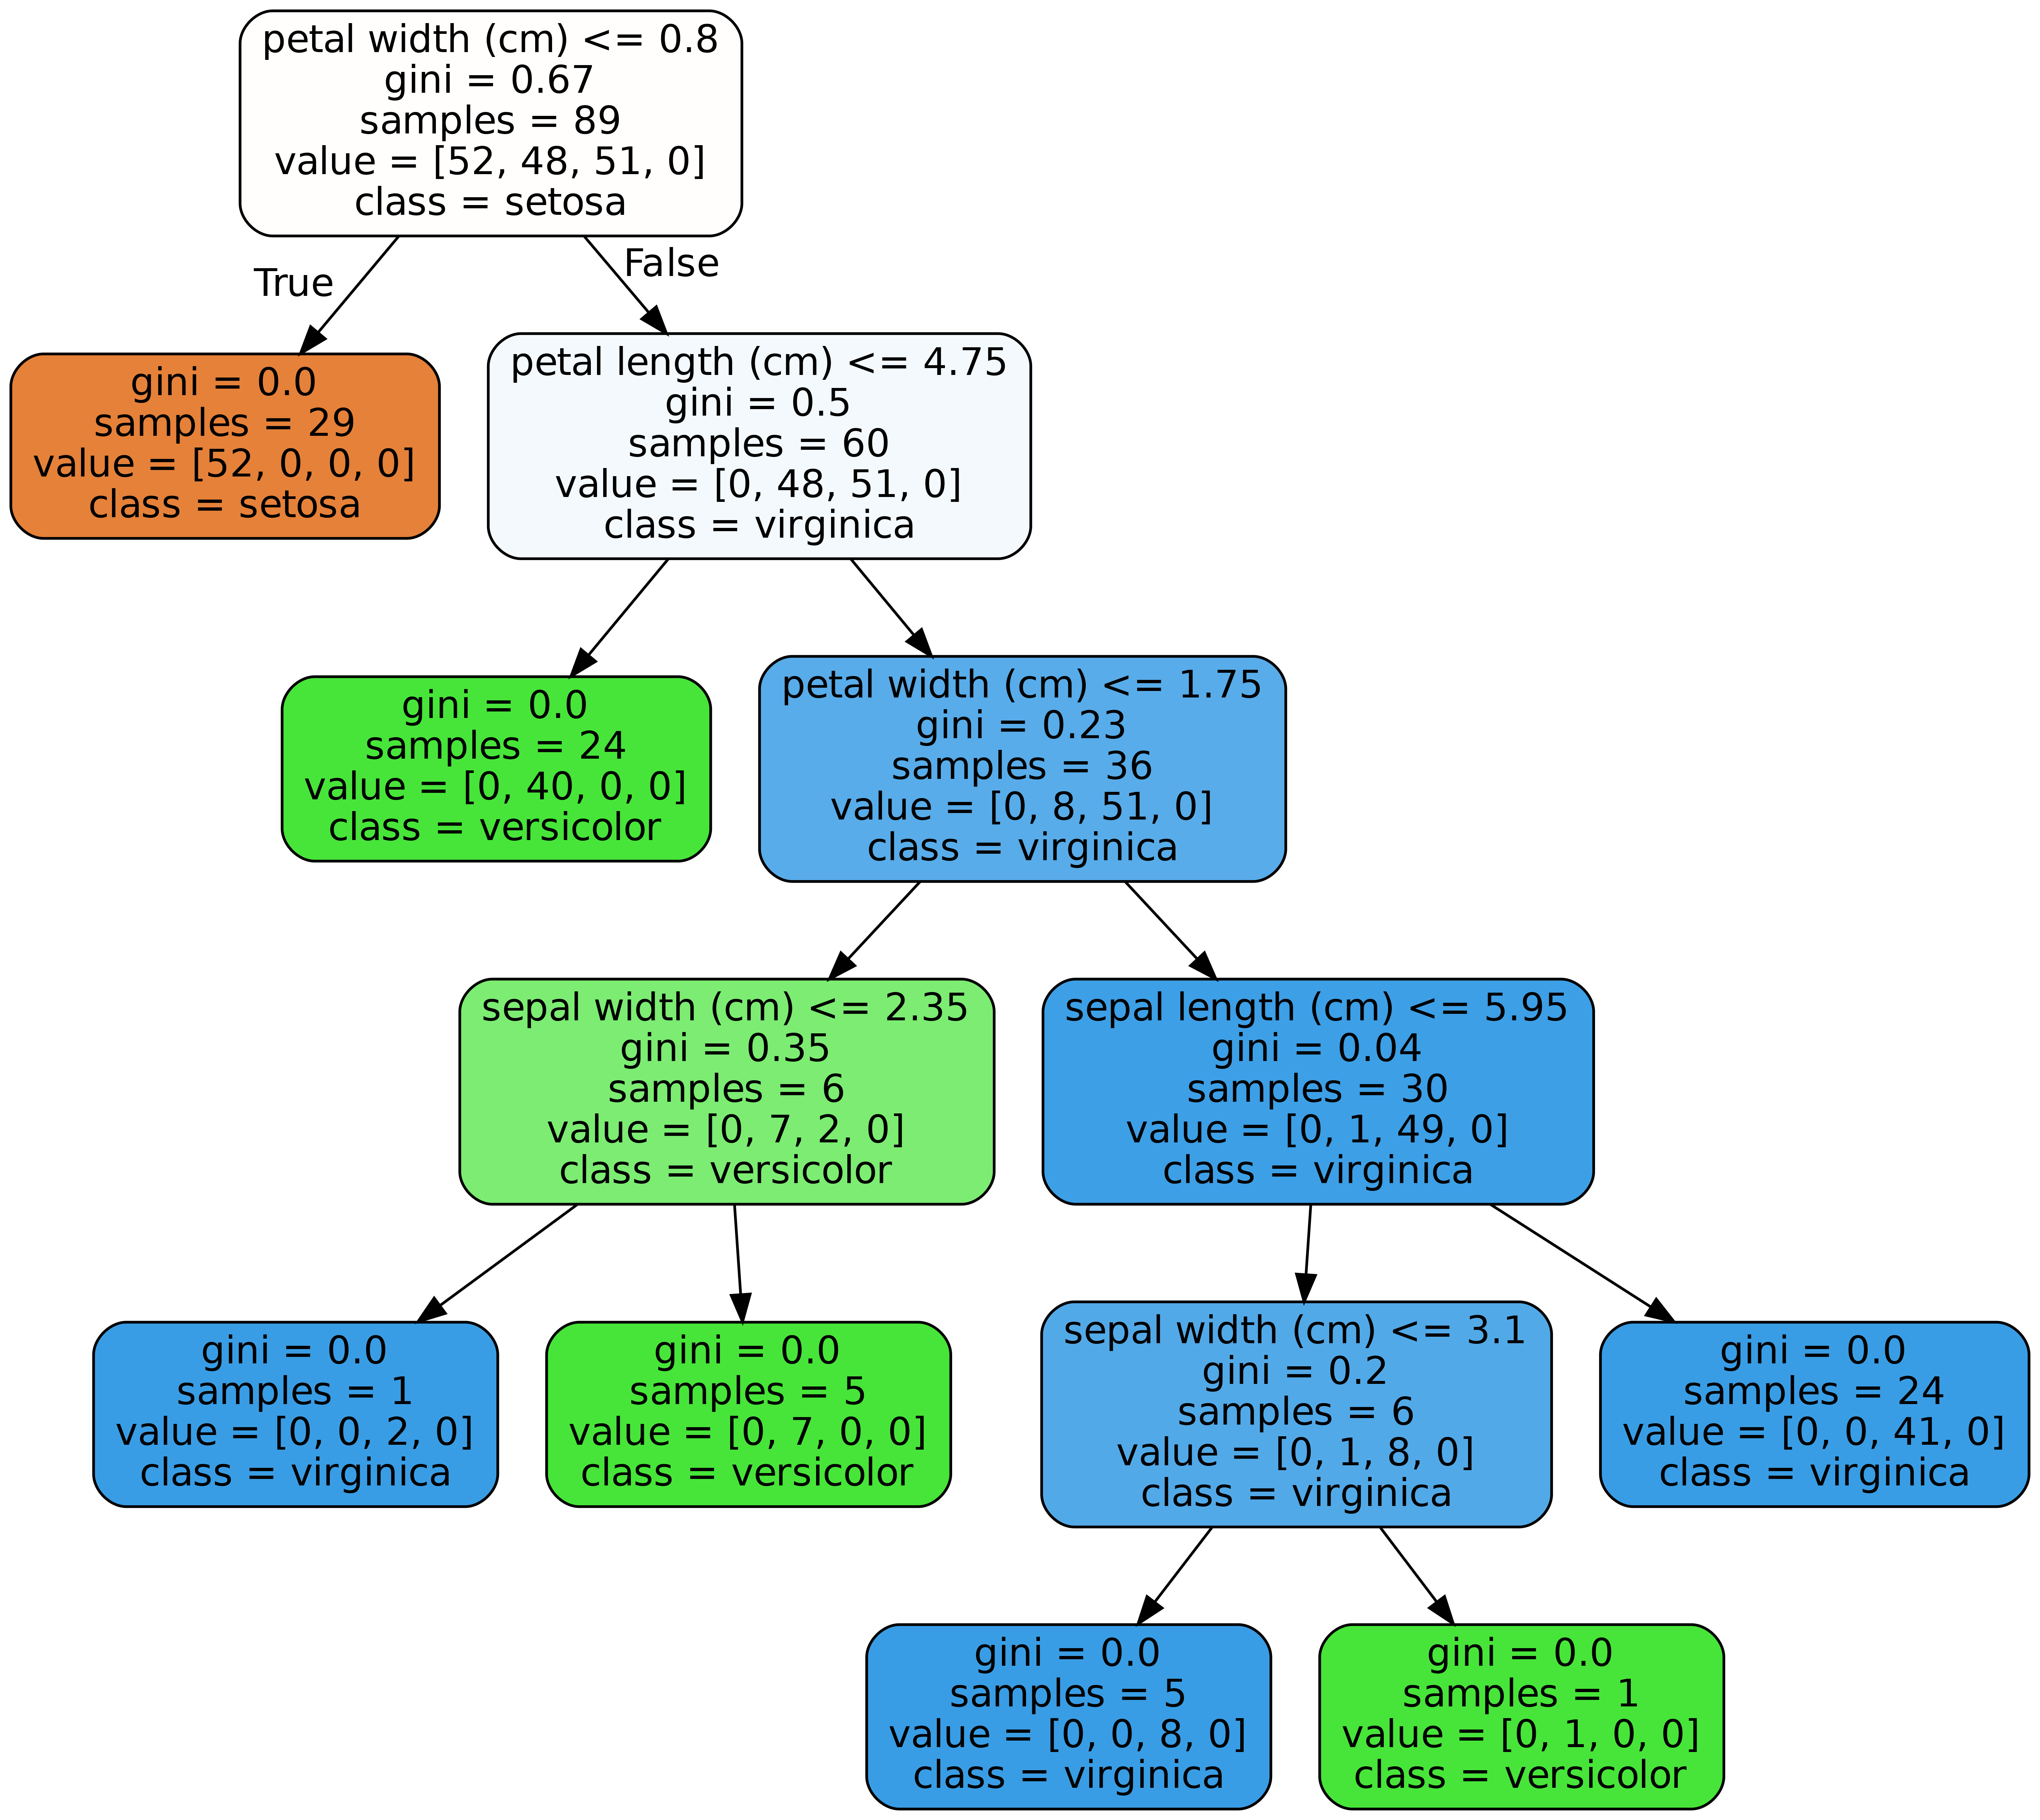

In [4]:
# example code with no safety

from sklearn.ensemble import RandomForestClassifier

rawRF = RandomForestClassifier(max_depth=5,random_state=1)
rawRF.fit(X,y)

print(f'Training set accuracy in this naive case is {rawRF.score(X,y)}')

estimator = rawRF.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

#fig,ax = plt.subplots(1,1,figsize=(15,10))
#output = plot_tree(rawDT,filled=True, ax=ax,fontsize=11)




### As we can see we have several disclosive nodes, one of which is our added point (in purple)
The exact values cannot be inferred but if we (reasonably) assume all features are non-negative we can get uper and lower bounds for the attribute values on that node:  
> (6.95,inf),  \[0,2.6\],  (0,4.95\],  (0.8, 1.65\]

so this is disclosive to a certain degree.

- In this case I spent 5 minutes manually tuning the values of the added point so that the tree included at least one decision node for each feature

- It would be fairly trivial to use something like a Genetic Algorithm to automatically tune the feature values of the added point minimising the difference between the upper and lower bounds for each feature.

- But that is not really the point of this exercise which was to show that allowing the user to set inappropriate values for a single parameter could produce a disclosive tree. 


### Diligent user realises problem, and changes their code to enforce at least n samples in each leaf
We'll use n=5 

Training set accuracy with threshold rule enforced is 0.9536423841059603


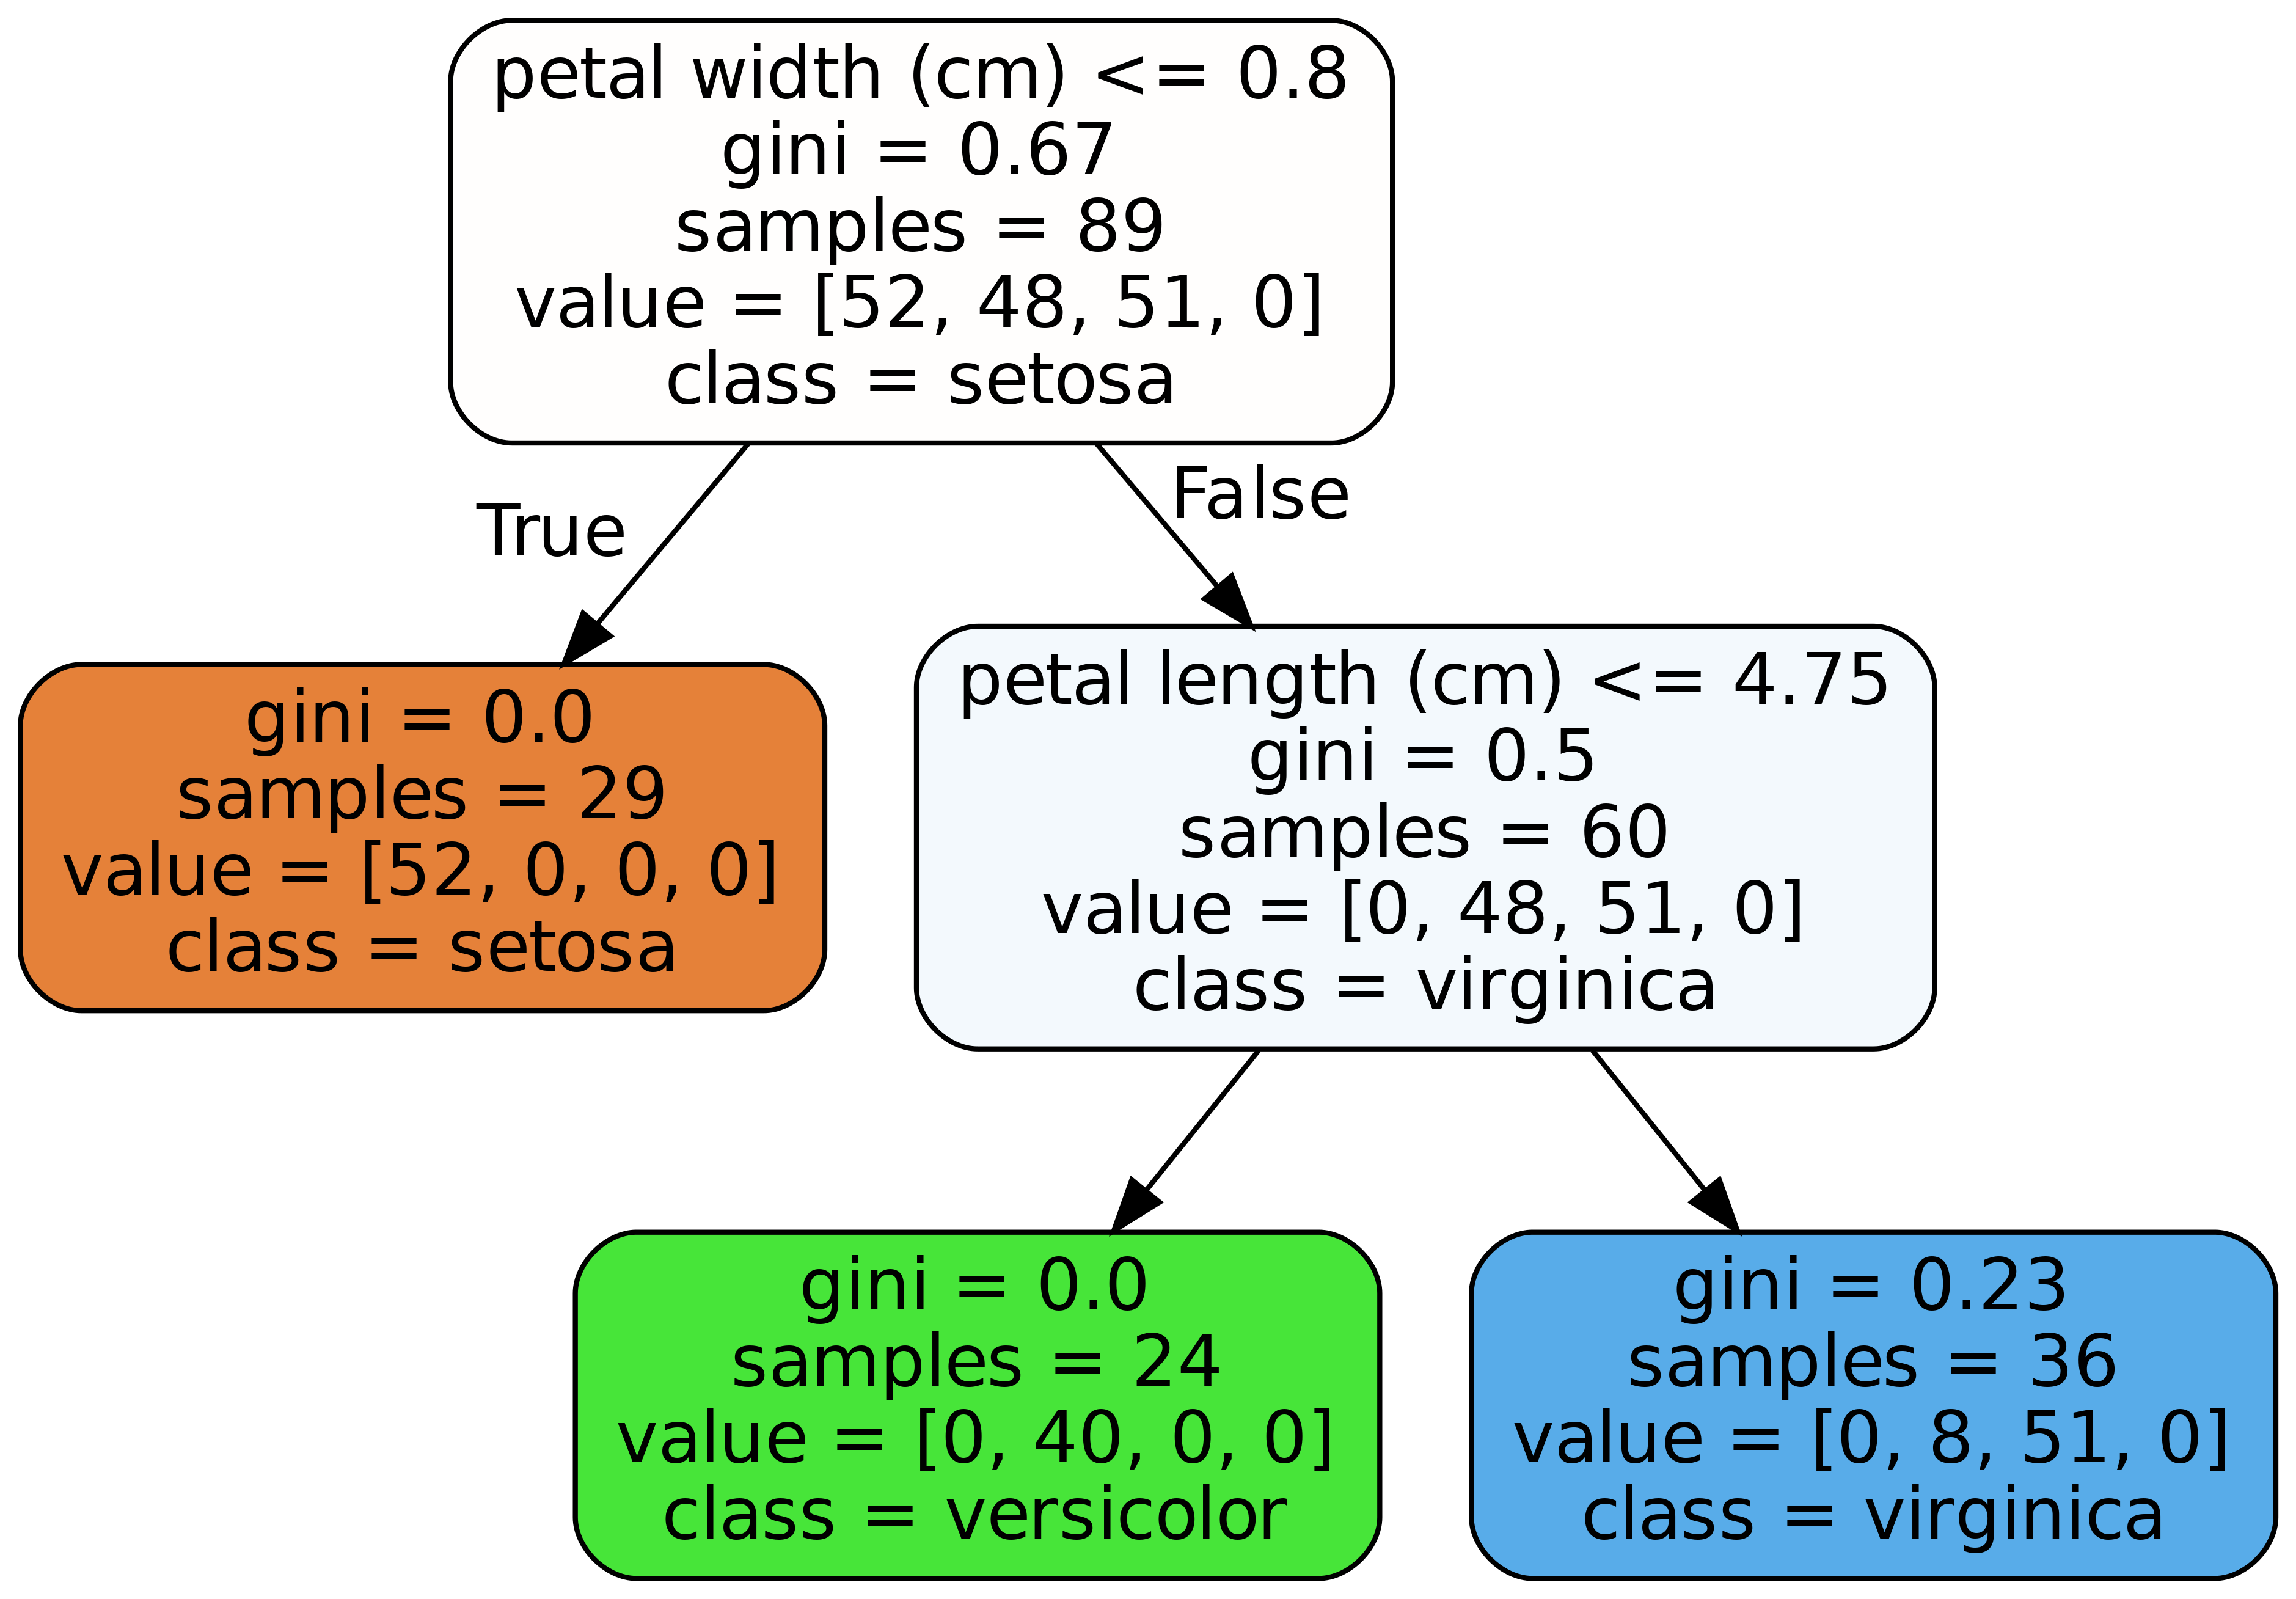

In [5]:
manualRF = RandomForestClassifier(max_depth=2,  random_state=1)
manualRF.fit(X,y)

print(f'Training set accuracy with threshold rule enforced is {manualRF.score(X,y)}')

estimator = manualRF.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')




### output is now non-disclosive (at least according to the threshold rule)
- You can easily see we don't get a node for the new class 3

## So lets define a new class SafeDecisionTree 
### after starting by removing the import of DecisionTreeClassfier

In [6]:
del RandomForestClassifier
try:
    shouldFail = RandomForestClassifier()
except:
    print('call failed correctly, so we know RandomForestClassifier cannot be accessed directly')

call failed correctly, so we know RandomForestClassifier cannot be accessed directly


In [7]:
import importlib, SafeModel
importlib.reload(SafeModel)




from SafeModel import SafeModel, SafeRandomForest

 

In [8]:

noNameModel = SafeModel()

try:
    print(noNameModel.__str__())
except:
    print("super class has no attributes to print")

super class has no attributes to print


In [9]:
safeRFModel= SafeRandomForest()#(criterion="entropy")
print(safeRFModel.__str__())

RandomForestClassifier with parameters: {'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), 'n_estimators': 100, 'estimator_params': ('criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'min_weight_fraction_leaf', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'random_state', 'ccp_alpha'), 'bootstrap': True, 'oob_score': False, 'n_jobs': None, 'random_state': None, 'verbose': 0, 'warm_start': False, 'class_weight': None, 'max_samples': None, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 5, 'min_weight_fraction_leaf'

Training set accuracy in this naive case is 0.9602649006622517


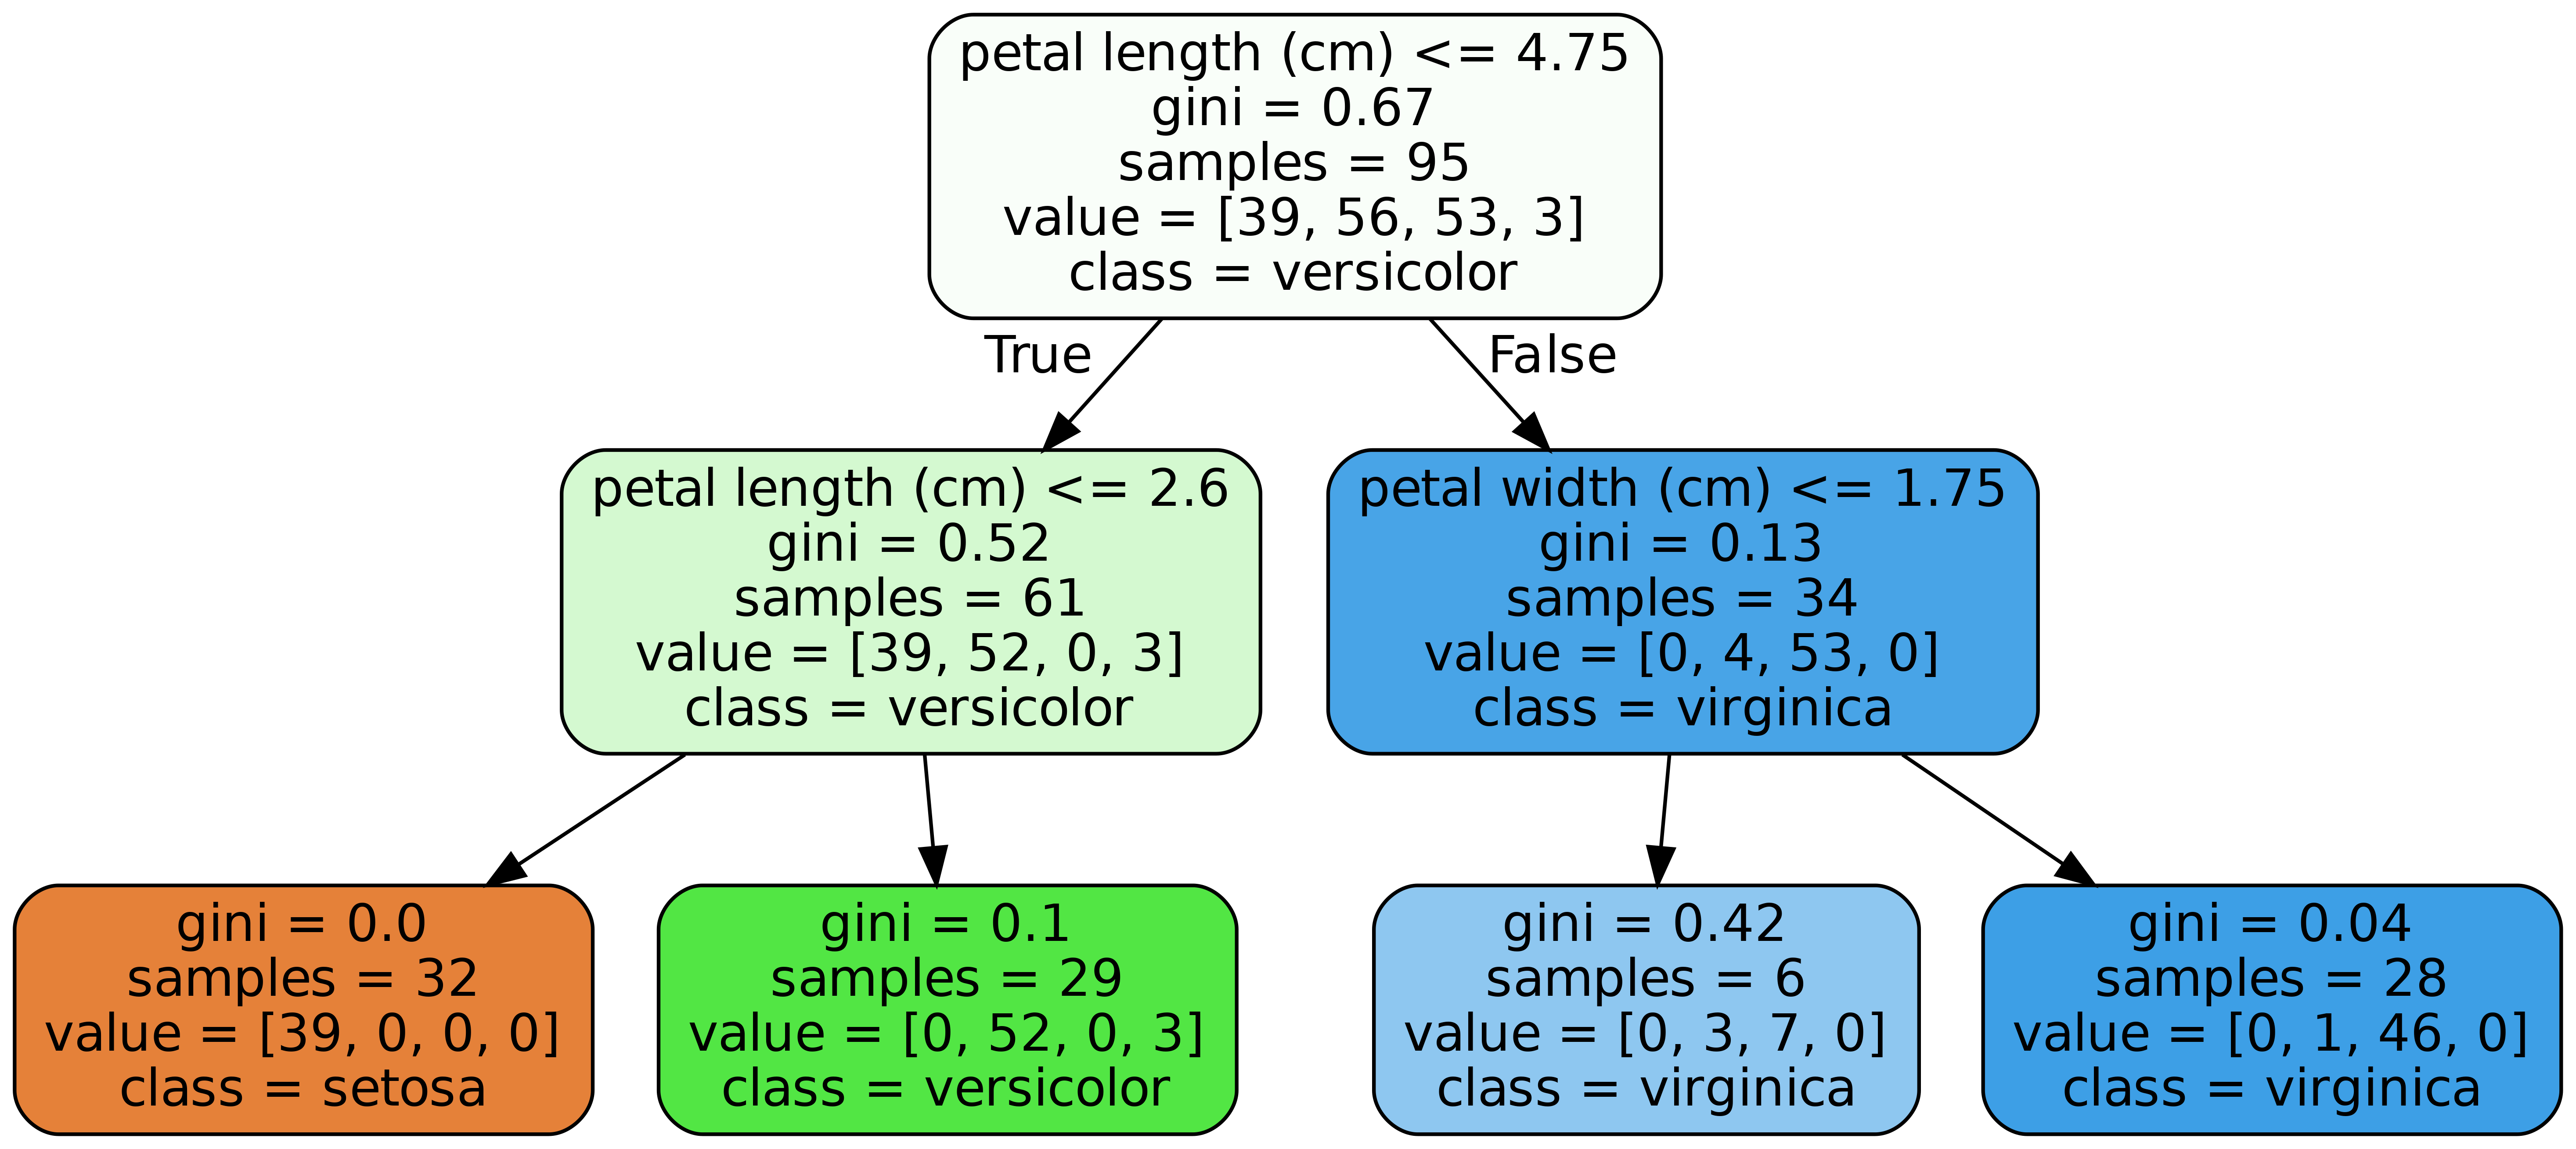

In [10]:
safeRFModel.fit(X,y)

print(f'Training set accuracy in this naive case is {safeRFModel.score(X,y)}')


estimator = safeRFModel.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')








## Now demonstrate the save and reporting functionality

In [11]:
safeRFModel.save_model(name="testSaveRF.pkl")
safeRFModel.preliminary_check()
#safeDTmodel.request_release()

checking key max_depth: current_val 2, recommended 2
checking key min_samples_leaf: current_val 5, recommended 5
Model has not been changed to increase risk of disclosure. These are the params:

	parameter min_samples_leaf unchanged at recommended value 5




## Now lets try to attack this approach
### starting with listing the params then trying to set the params manually after init

In [12]:
print(safeRFModel.__dict__)
print(safeRFModel.model)
print(safeRFModel.model.__dict__)

{'model_type': 'RandomForestClassifier', 'model': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), 'model_save_file': 'testSaveRF.pkl', 'filename': 'None', 'researcher': 'andy'}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5

Training set accuracy in this naive case is 0.9668874172185431


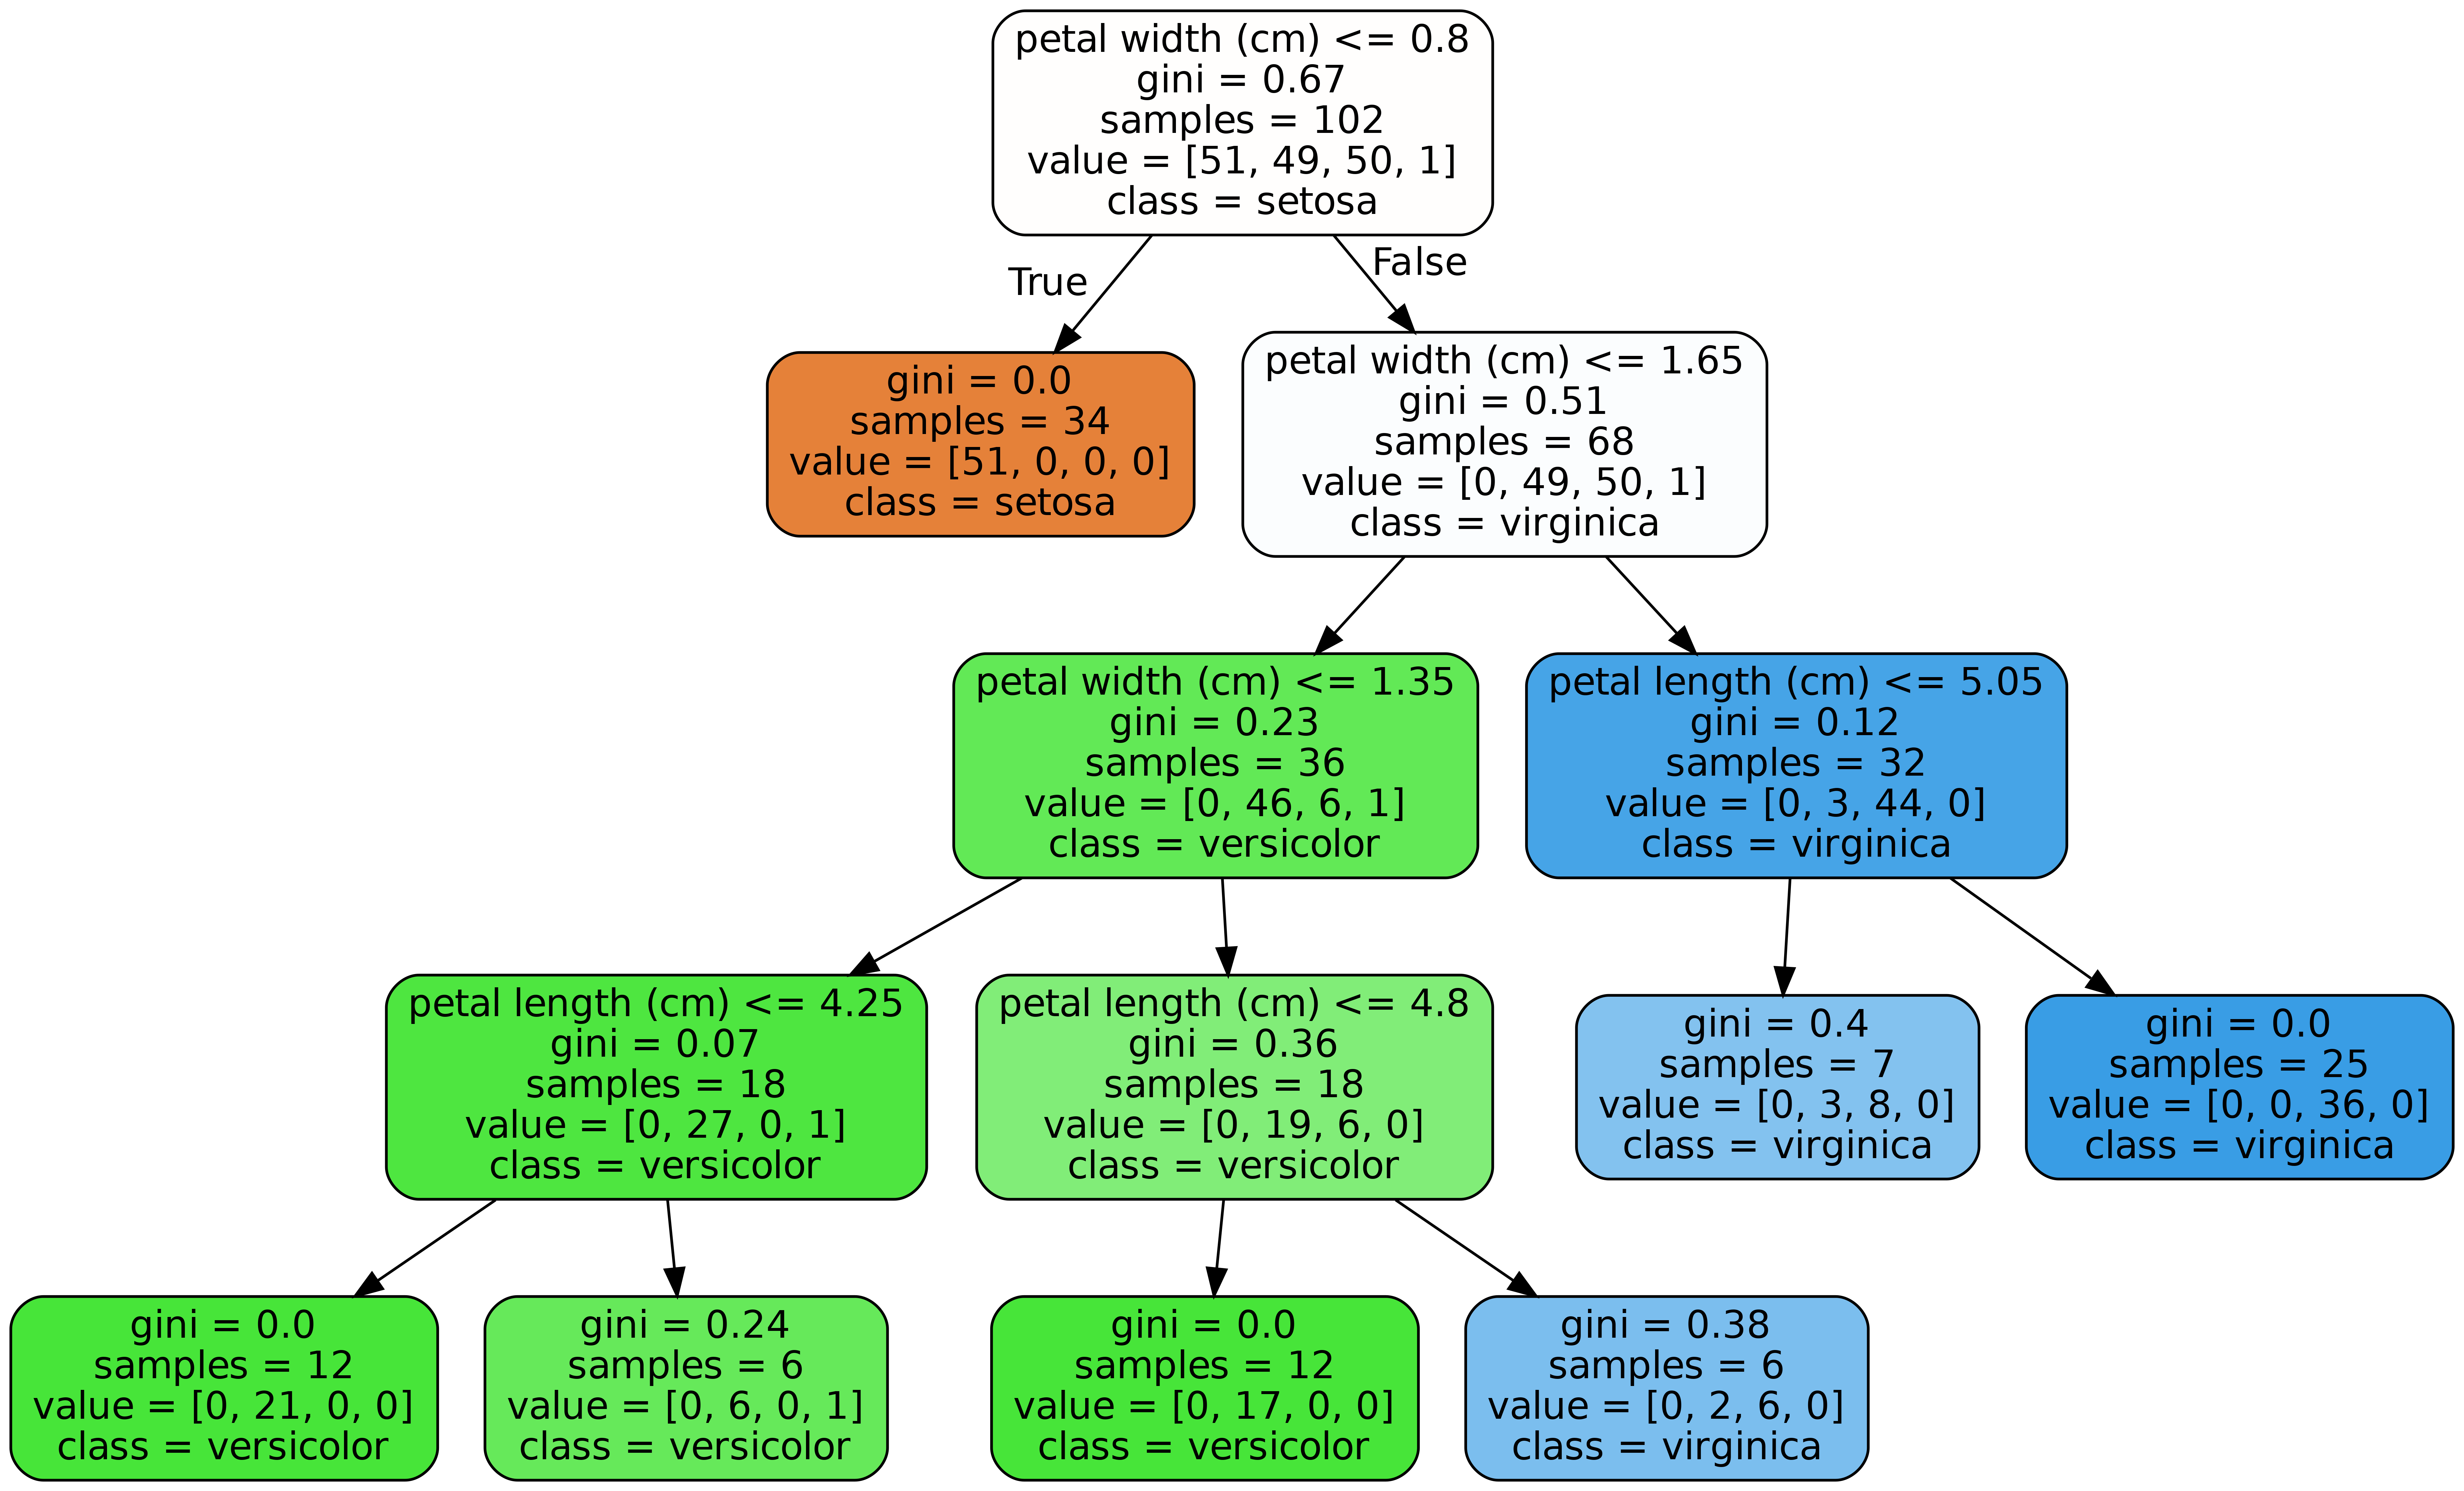

In [13]:
safeRFModel.model.max_depth=10

safeRFModel.fit(X,y)

print(f'Training set accuracy in this naive case is {safeRFModel.score(X,y)}')


estimator = safeRFModel.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')



### This has let the user reset the params so that the model is now disclosive once again.

## Question: what do we do here:
1. Find a way of obfuscating the params so that they cannot be changed from outside the wrapper class
  - hard, not very python esque
  - also what if the use wants to increase min_samples_leaf which would make the model less disclosive than the default values?
2. Put code into various method within the main class that checks the param values and says if they have been changed.
 - constraints are  stored the "safe" param values in a read-only file  
   and reads that into a dict in the init() and preliminaryCheck() and requestRelease() methods. 
    - The dict key is name of parameter name, value is a tuple of [operator, value]  
      where operator is one of ["min" |"equals" | "max"] and value is applied to operator
    - the dict is read afresh in __init__() and in makeReport() to prevent users amending values 
 - this would have the benefit of allowing users to increase the min_samples_leaf but report when it was taken below our threshold
 
 - issue is how to deal with situations where the safety is built from a non-linear interaction between param values
   - that is a problem to deal with in the second stage of the project once we have proved the concept
 

In [14]:
# create and fit using recomended params
print("***researcher doesn't change recomended params")
safeRFModel2= SafeRandomForest()
safeRFModel2.fit(X,y)
safeRFModel2.save_model(name="safe2.pkl")
safeRFModel2.preliminary_check()
safeRFModel2.request_release(filename="safe2.pkl")





# change model params to recommended values
print("\n***researcher changes params safely")
safeRFModel3= SafeRandomForest()
safeRFModel3.model.max_depth=5
safeRFModel3.fit(X,y)
safeRFModel3.save_model(name="safe3.pkl")
safeRFModel3.preliminary_check()
safeRFModel3.request_release(filename="safe3.pkl")



# change model params in a safe way
print("\n***researcher changes params safely")
safeRFModel4= SafeRandomForest()
safeRFModel4.model.max_depth=1
safeRFModel4.fit(X,y)
safeRFModel4.save_model(name="safe4.pkl")
safeRFModel4.preliminary_check()
safeRFModel4.request_release(filename="safe4.pkl")





# change model params in an  unsafe way
print("\n***researcher changes params unsafely")
safeRFModel5= SafeRandomForest()
safeRFModel5.model.max_depth=15
safeRFModel5.save_model(name="unsafe.pkl")
safeRFModel5.preliminary_check()
safeRFModel5.request_release(filename= "unsafe.pkl")



***researcher doesn't change recomended params
checking key max_depth: current_val 2, recommended 2
checking key min_samples_leaf: current_val 5, recommended 5
Model has not been changed to increase risk of disclosure. These are the params:

	parameter min_samples_leaf unchanged at recommended value 5


checking key max_depth: current_val 2, recommended 2
checking key min_samples_leaf: current_val 5, recommended 5

***researcher changes params safely
checking key max_depth: current_val 5, recommended 2
checking key min_samples_leaf: current_val 5, recommended 5

	parameter min_samples_leaf unchanged at recommended value 5


checking key max_depth: current_val 5, recommended 2
checking key min_samples_leaf: current_val 5, recommended 5

***researcher changes params safely
checking key max_depth: current_val 1, recommended 2
checking key min_samples_leaf: current_val 5, recommended 5
Model has not been changed to increase risk of disclosure. These are the params:

	parameter min_samples_

In [15]:
!ls; echo "contents of checkfile are"; cat *_check*ile.txt


andy_checkfile.txt  requirements.md  testSave.pkl    untitled
grep		    safe2.pkl	     testSaveRF.pkl  wrapper-concept.ipynb
Jim_checkFile.txt   safe3.pkl	     tree.dot	     wrapper-RF-concept.ipynb
params.txt	    safe4.pkl	     tree.png
__pycache__	    SafeModel.py     unsafe.pkl
contents of checkfile are
andy created model of type DecisionTreeClassifier saved as safe2.pkl
Model has not been changed to increase risk of disclosure. These are the params:
 	parameter min_samples_leaf unchanged at recommended value 5
andy created model of type DecisionTreeClassifier saved as safe3.pkl
Model has not been changed to increase risk of disclosure. These are the params:
 	parameter min_samples_leaf unchanged at recommended value 5
andy created model of type DecisionTreeClassifier saved as safe4.pkl
Model has not been changed to increase risk of disclosure. These are the params:
 	parameter min_samples_leaf increased from recommended min value of 5 to 10. This is not problematic.

andy created m